In [95]:
# Imports
import pandas as pd
import numpy as np
import yfinance as yf
import hvplot.pandas
import seaborn as sn

from finta import TA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report


In [64]:
# Setup environment variables
model  = SVC()
scaler = MinMaxScaler()

In [2]:
# Function to Retrieve ticker data
def ticker_data_history(ticker, column_drop, rename_column, per = 'max', int_period = '1wk'):
    x =yf.Ticker(ticker)                                      # Get ticker data
    x_data = x.history(period=per,interval = int_period)      # Extract historical data 
    x_data = x_data.dropna()                                  # Remove any nas
    if column_drop != "":                                     # If there are any columns to drop
        x_data = x_data.drop(columns=column_drop)             # drop those columns
    if rename_column != "":                                   # Rename 'Close' to given name
        x_data = x_data.rename(columns = {'Close':rename_column}) 

    return x_data                                             # Return the requested data

In [3]:
# Retrieve ticker data
drop_columns = ['Dividends','Stock Splits' ,'Low','High','Open','Volume']
tickers = ['SPY', 'XLK', 'XLV', 'XLI', 'XLP', 'XLE', 'XLY', 'XLB']  # Tickers to get data            
df_data = pd.DataFrame()
for ticker in tickers:
    df_data[ticker] = ticker_data_history(ticker, drop_columns, ticker)
df_data.dropna(inplace=True)                                        # Drop any nas    

In [4]:
df_data

,SPY,XLK,XLV,XLI,XLP,XLE,XLY,XLB
Date,,,,,,,,
1998-12-21,80.237930,25.085405,18.453289,15.841219,15.923187,13.405275,19.861286,12.834346
1998-12-28,80.646690,25.037436,18.632439,16.212488,15.959926,13.245687,19.920856,13.067194
1999-01-04,83.548843,26.764154,19.337868,16.645651,15.895642,13.600321,20.707209,13.812288
1999-01-11,81.341568,26.692205,19.225901,16.078424,15.353866,12.891052,19.956606,13.160328
1999-01-18,80.156174,26.668228,19.113926,15.531816,14.922254,12.820124,20.182966,12.564251
...,...,...,...,...,...,...,...,...
2022-05-16,387.954163,131.059998,129.779999,89.739998,70.699997,81.769997,140.410004,82.419998
2022-05-23,413.473907,141.460007,134.020004,95.470001,75.000000,88.529999,153.759995,87.360001
2022-05-30,408.774231,139.990005,129.820007,95.550003,73.820000,89.510002,153.000000,86.669998


In [5]:
# calculate correlation
correlation = df_data.corr()
correlation

,SPY,XLK,XLV,XLI,XLP,XLE,XLY,XLB
SPY,1.000000,0.969831,0.990768,0.988943,0.971948,0.568453,0.995624,0.972640
XLK,0.969831,1.000000,0.940507,0.927056,0.901864,0.404915,0.961553,0.905590
XLV,0.990768,0.940507,1.000000,0.988486,0.987660,0.594233,0.990740,0.970611
XLI,0.988943,0.927056,0.988486,1.000000,0.983361,0.645547,0.985614,0.983750
XLP,0.971948,0.901864,0.987660,0.983361,1.000000,0.659939,0.972799,0.969875
XLE,0.568453,0.404915,0.594233,0.645547,0.659939,1.000000,0.553307,0.716243
XLY,0.995624,0.961553,0.990740,0.985614,0.972799,0.553307,1.000000,0.969035
XLB,0.972640,0.905590,0.970611,0.983750,0.969875,0.716243,0.969035,1.000000


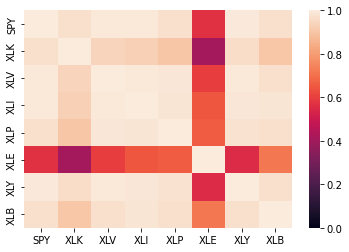

In [6]:
correlation_map = sn.heatmap(correlation,vmin = 0.0,vmax=1.0)  
figure = correlation_map.get_figure()    
figure.savefig('correlation_map.png', dpi=100)

In [7]:
# Get TRX Gold Corp data from yahoo finance
drop_columns = ['Dividends','Stock Splits']
period   ='2y'
interval ='1h'
ticker   = '^TNX'
tnx = ticker_data_history(ticker, drop_columns, "", period, interval)

ticker = 'XLE'
xlk = ticker_data_history(ticker, drop_columns, "", period, interval)


In [8]:
# Make the both dataframe same length
if len(tnx) > len(xlk):
    tnx = tnx.iloc[(len(tnx) - len(xlk)):]
elif len(tnx) < len(xlk):
    xlk = xlk.iloc[len(xlk) - len(tnx):]
    

In [9]:
# Calculate Exponential Weighted Moving Average using Finta lib and
# Set buy_signal

ema = pd.DataFrame(TA.EMA(xlk,9), index = xlk.index)        # EMA with 9 periods
ema = ema.rename(columns = {'9 period EMA' : 'ema_5'})      # Rename the column
ema['ema_21'] = TA.EMA(xlk,21)                              # EMA with 21 periods
ema['signal'] = 0.0                                         # Set column name = 'signal'
ema['signal'][9:]=np.where(ema['ema_5'][9:]>ema['ema_21'][9:],1.0,0.0) # calculate signal
ema.head()

,ema_5,ema_21,signal
2020-06-19 12:30:00-04:00,40.049999,40.049999,0.0
2020-06-19 13:30:00-04:00,39.922222,39.929523,0.0
2020-06-19 14:30:00-04:00,40.003278,39.999153,0.0
2020-06-19 15:30:00-04:00,39.849728,39.870340,0.0
2020-06-22 09:30:00-04:00,39.591004,39.656822,0.0


In [41]:
# Create sector data frame
col = ["Close", "tnx", "ema_5", "ema_21", "signal", "entry/exit"]
sector_data = pd.DataFrame(columns = col, index=ema.index)
sector_data['Close']  = xlk['Close'].values                      # Add xlk Close price column
sector_data['tnx']    = tnx['Close'].values                      # Add xlk Close tnx column
sector_data['ema_5']  = ema['ema_5'].values                      # Add ema_5 column
sector_data['ema_21'] = ema['ema_21'].values                     # Add ema_21 column
sector_data['signal'] = ema['signal'].values                     # Add signal column
sector_data['entry/exit'] = ema['signal'].diff()                 # Calculate and Add diff on signal
sector_data.dropna(inplace=True)                                 # Drop any nas and assign to new DF=sector_data
sector_data.head()

,Close,tnx,ema_5,ema_21,signal,entry/exit
2020-06-19 13:30:00-04:00,39.820000,0.681,39.922222,39.929523,0.0,0.0
2020-06-19 14:30:00-04:00,40.119999,0.679,40.003278,39.999153,0.0,0.0
2020-06-19 15:30:00-04:00,39.549999,0.681,39.849728,39.870340,0.0,0.0
2020-06-22 09:30:00-04:00,38.980000,0.697,39.591004,39.656822,0.0,0.0
2020-06-22 10:30:00-04:00,38.869999,0.702,39.395571,39.492585,0.0,0.0


#  X features :
 - Creating X features using RSI value of xlk

In [51]:
# RSI Calculation
xlk_rsi = pd.DataFrame(TA.RSI(xlk))                         # Calculate RSI value
xlk_rsi = xlk_rsi.dropna()                                  # Drop any nas
xlk_rsi = xlk_rsi[xlk_rsi['14 period RSI'] != 100.000000]   # drop any rows where '14 period RSI' = 100.000000

try:
    sector_data.insert(2,'rsi_14',xlk_rsi['14 period RSI']) # Insert rsi to df=sector_data
except:
    sector_data['rsi_14'] = xlk_rsi['14 period RSI']        # Add rsi to df=sector_data

sector_data.dropna(inplace=True)                            # Drop any nas
X_feature = sector_data.iloc[:,:4]                          # Extract first 4 columns for X-Feature
#sector_data
X_feature

,Close,tnx,rsi_14,ema_5
2020-06-19 13:30:00-04:00,39.820000,0.681,0.000000,39.922222
2020-06-19 14:30:00-04:00,40.119999,0.679,58.414451,40.003278
2020-06-19 15:30:00-04:00,39.549999,0.681,26.609452,39.849728
2020-06-22 09:30:00-04:00,38.980000,0.697,16.773970,39.591004
2020-06-22 10:30:00-04:00,38.869999,0.702,15.577345,39.395571
...,...,...,...,...
2022-06-17 12:30:00-04:00,73.279999,3.229,21.675733,75.962003
2022-06-17 13:30:00-04:00,74.055000,3.212,26.394183,75.580603
2022-06-17 14:30:00-04:00,74.339996,3.222,28.109311,75.332481
2022-06-17 15:30:00-04:00,73.500000,3.239,26.173473,74.965985


# Setup train/test data

In [90]:
# Select y value and setup training/testing data
y = sector_data.iloc[:,-2].values           # Select column = 'signal' as y value
split   = int(0.75*len(xlk))                # Split 75% of data based on xlk's total data
X_train = X_feature[:split]                 # Assign 75% to X_train
X_test  = X_feature[split:]                 # Assign 25% to X_test
y_train = y[:split]                         # Assign 75% to y_train
y_test  = y[split:]                         # Assign 25% to y_train

# Shape, fit, scale  and train data
X_train.shape                               # Shape the X_train data
y_test.shape                                # Shape the y_test data
x_train_scaled = scaler.fit(X_train)        # Fit the X_train data using MinMaxScaler
x_train_scaled = scaler.transform(X_train)  # Now, scale the feature training
x_test_scaled  = scaler.transform(X_test)   # Now, scale the feature testing
model.fit(x_train_scaled, y_train)          # Train the model using sklearn.svm
predictions = model.predict(x_test_scaled)  # Get the predition from the model


In [91]:
# Print classification report
report_test = classification_report(y_test,predictions)
print(report_test)

              precision    recall  f1-score   support

         0.0       0.44      0.96      0.60       294
         1.0       0.95      0.38      0.54       585

    accuracy                           0.57       879
   macro avg       0.69      0.67      0.57       879
weighted avg       0.78      0.57      0.56       879



In [92]:
y_test = pd.DataFrame(y_test,columns =['y_t'])                # Convert y_test and name the column
display(y_test.head())

predictions = pd.DataFrame(predictions,columns = ['pred'])    # Create df of preditions
predictions['y_pred'] = predictions['pred'].diff()            # Calculate diff() based on 'pred'
predictions['y_actual'] = y_test['y_t'].diff()                # Add & calculate y_actual
predictions.dropna(inplace=True)                              # Drop all nas
predictions['close'] = X_feature.iloc[split+1:,0].values      # Add close price from X_feature
display(predictions.head())


,y_t
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


,pred,y_pred,y_actual,close
1,0.0,0.0,0.0,54.590000
2,0.0,0.0,0.0,54.360001
3,0.0,0.0,0.0,52.400002
4,0.0,0.0,0.0,52.209999
5,0.0,0.0,0.0,52.555000


In [93]:
days_bought=predictions[predictions['y_actual']== -1.0]
days_bought

,pred,y_pred,y_actual,close
56,0.0,0.0,-1.0,55.590000
157,0.0,0.0,-1.0,62.080002
245,0.0,0.0,-1.0,68.339996
260,0.0,0.0,-1.0,68.349998
271,0.0,0.0,-1.0,68.349998
290,0.0,0.0,-1.0,68.220001
386,0.0,0.0,-1.0,74.989998
403,0.0,0.0,-1.0,74.739998
477,0.0,0.0,-1.0,76.349998
503,0.0,0.0,-1.0,76.550003


In [104]:
entry = predictions[predictions['y_pred'] == 1.0]['close'].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize exit positions relative to close price
exit = predictions[predictions['y_pred'] == -1.0]['close'].hvplot.scatter(
    color='orange',
    marker='v',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the close price for the investment
security_close = predictions[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)


# Overlay the plots
entry_exit_plot = security_close *  entry * exit
entry_exit_plot.opts(
    title="Short-Position Dual Moving Average Trading Algorithm"
)


:Overlay
   .Curve.I          :Curve   [index]   (close)
   .Scatter.Close.I  :Scatter   [index]   (close)
   .Scatter.Close.II :Scatter   [index]   (close)